Compare Condensability score and C-half

In [1]:
# python modules
import copy
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import stats


In [2]:
# custom modules
import graphics_edit as graphics

In [3]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"

In [4]:
# custom modules
import load_file_edit as load_file

In [5]:
path = "./data/"

In [6]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}

In [7]:
### exp list
### exp = (rep, cell, sample, agent, tnum)
exp_list = [(1, 'H1', 'NCP', 'sp', 8),
            (2, 'H1', 'NCP', 'sp', 8),
            (1, 'H1', 'NCP', 'HP1a', 3),
            (2, 'H1', 'NCP', 'HP1a', 3),
            (1, 'H1', 'DNA', 'HP1a', 3),
            (2, 'H1', 'DNA', 'HP1a', 3),
            (1, 'GM', 'NCP', 'sp', 8),
            (2, 'GM', 'NCP', 'sp', 8)]

exp_list = [(1, 'H1', 'NCP', 'sp', 8),
            (2, 'H1', 'NCP', 'sp', 8),
            (1, 'GM', 'NCP', 'sp', 8),
            (2, 'GM', 'NCP', 'sp', 8)]

exp_list = [(1, 'mCD8T:WT', 'NCP', 'sp', 8),
            (2, 'mCD8T:WT', 'NCP', 'sp', 8),
            (1, 'mCD8T:DFMO', 'NCP', 'sp', 8),
            (2, 'mCD8T:DFMO', 'NCP', 'sp', 8),
            (1, 'mCD8T:ODCKO', 'NCP', 'sp', 8),
            (2, 'mCD8T:ODCKO', 'NCP', 'sp', 8)]



deep = False
bin_size = 10000
cp_percent = 80


In [8]:
# 4-parameter logistic function (sigmoid type)
def sigmoid_func (x, top, rate, chalf, bottom):
    y = bottom + float(top-bottom)/(1+np.exp(rate*(x-chalf)))
    return y

# 4-parameter logistic function (Hill type)
def hill_func (x, top, rate, chalf, bottom):
    y = bottom + float(top-bottom)/(1.0 + (x/float(chalf))**rate)
    return y

# compute the CP value of logistic function
def get_CP (rate, chalf, percent, model='sigmoid'):
    surv_frac = 1 - percent/100.0
    ratio = float(1.0 - surv_frac)/surv_frac
    if model == 'sigmoid':
        CP = np.log(ratio)/float(rate) + chalf
    elif model == 'hill':
        CP = ((ratio)**(1.0/rate)) * chalf
    return CP

In [9]:
### read data
dexp_list = []
dexp_ID_field_value = {}
for exp in exp_list:
    rep, cell, sample, agent, tnum = exp
    chr_choices = cell_chrnames[cell]

    fname_terms = [cell,
                   sample,
                   agent,
                   str(rep) + 'rep',
                   str(int(bin_size/1000.0)) + 'kb']

    # load score
    score_fname = '_'.join(fname_terms + ['score']) + '.cn'
    score_field_name = '_'.join([cell,
                                 sample,
                                 agent,
                                 str(tnum),
                                 str(rep) + 'rep'])
    ID_score = load_file.read_cn_file(path + score_fname,
                                      mode='col',
                                      field_choices=[score_field_name],
                                      chr_choices=chr_choices)[score_field_name]


    # load 4PL file (sigmoid)
    sigmoid_fname = '_'.join(fname_terms + ['sigmoid_4PL']) + '.cn'

    ID_field_param_sigmoid = load_file.read_cn_file(path + sigmoid_fname,
                                                    mode='row',
                                                    chr_choices=chr_choices)

    

    # load 4PL file (hill)
    hill_fname = '_'.join(fname_terms + ['hill_4PL']) + '.cn'

    ID_field_param_hill = load_file.read_cn_file(path + hill_fname,
                                                mode='row',
                                                chr_choices=chr_choices)

    
    ID_field_value = {}
    for ID in ID_score:
        #ID_field_value[ID] = {}
        #ID_field_value[ID]['score'] = ID_score[ID]
        #continue
    
        try:
            # get CP of 4PL model (sigmoid)
            top = ID_field_param_sigmoid[ID]['Top']
            rate_sigmoid = ID_field_param_sigmoid[ID]['Rate']
            chalf_sigmoid = ID_field_param_sigmoid[ID]['C-half']
            bottom = ID_field_param_sigmoid[ID]['Bottom']

            CP_sigmoid = get_CP (rate_sigmoid,
                                 chalf_sigmoid,
                                 cp_percent,
                                 model = 'sigmoid')

        except:
            continue

        
        try:
            # get CP of 4PL model (hill)
            top = ID_field_param_hill[ID]['Top']
            rate_hill = ID_field_param_hill[ID]['Rate']
            #rate_hill = ID_field_param_hill[ID]['Hill']
            chalf_hill = ID_field_param_hill[ID]['C-half']
            bottom = ID_field_param_hill[ID]['Bottom']

            CP_hill = get_CP (rate_hill,
                              chalf_hill,
                              cp_percent,
                              model = 'hill')

        except:
            continue
        

        ID_field_value[ID] = {}
        ID_field_value[ID]['score'] = ID_score[ID]
        ID_field_value[ID]['rate_sigmoid'] = rate_sigmoid
        ID_field_value[ID]['rate_hill'] = rate_hill
        ID_field_value[ID]['CP_sigmoid'] = CP_sigmoid
        ID_field_value[ID]['CP_hill'] = CP_hill

    dexp = (rep, cell, sample, agent)
    dexp_list.append(dexp)
    dexp_ID_field_value[dexp] = ID_field_value


In [10]:
### get common IDs
ID_list = set([])
for i in range(len(dexp_list)):
    dexp = dexp_list[i]
    if i == 0:
        ID_list |= set(dexp_ID_field_value[dexp].keys())
        continue
    ID_list &= set(dexp_ID_field_value[dexp].keys())
ID_list = sorted(list(ID_list))


(1, 'mCD8T:WT', 'NCP', 'sp') score
(1, 'mCD8T:WT', 'NCP', 'sp') CP_sigmoid
Spearman: -0.69
Pearson: -0.68


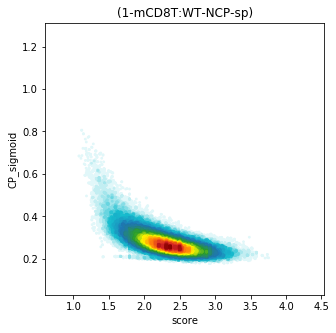



(1, 'mCD8T:WT', 'NCP', 'sp') score
(1, 'mCD8T:WT', 'NCP', 'sp') rate_sigmoid
Spearman: 0.59
Pearson: 0.36


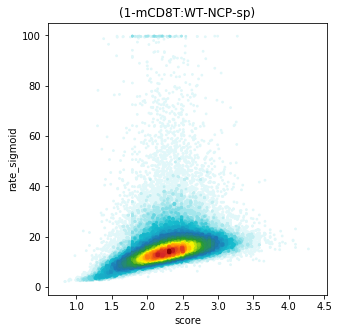



(1, 'mCD8T:WT', 'NCP', 'sp') CP_sigmoid
(1, 'mCD8T:WT', 'NCP', 'sp') rate_sigmoid
Spearman: -0.82
Pearson: -0.55


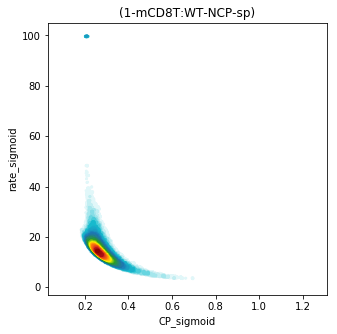



(2, 'mCD8T:WT', 'NCP', 'sp') score
(2, 'mCD8T:WT', 'NCP', 'sp') CP_sigmoid
Spearman: -0.66
Pearson: -0.65


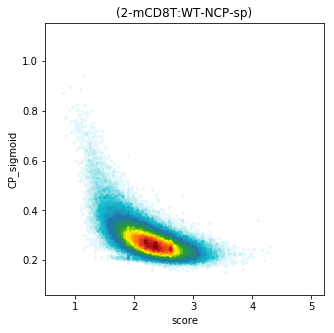



(2, 'mCD8T:WT', 'NCP', 'sp') score
(2, 'mCD8T:WT', 'NCP', 'sp') rate_sigmoid
Spearman: 0.51
Pearson: 0.29


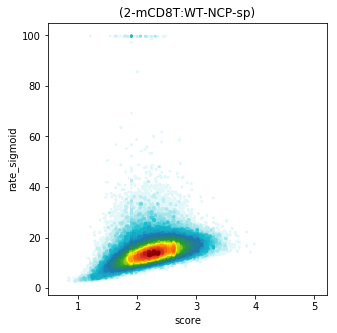



(2, 'mCD8T:WT', 'NCP', 'sp') CP_sigmoid
(2, 'mCD8T:WT', 'NCP', 'sp') rate_sigmoid
Spearman: -0.79
Pearson: -0.53


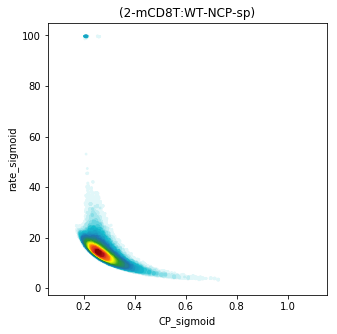



(1, 'mCD8T:DFMO', 'NCP', 'sp') score
(1, 'mCD8T:DFMO', 'NCP', 'sp') CP_sigmoid
Spearman: -0.77
Pearson: -0.77


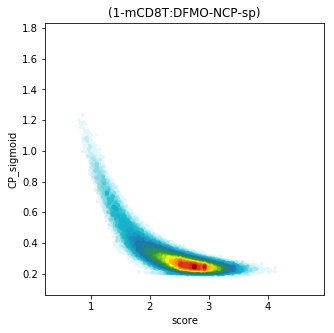



(1, 'mCD8T:DFMO', 'NCP', 'sp') score
(1, 'mCD8T:DFMO', 'NCP', 'sp') rate_sigmoid
Spearman: 0.70
Pearson: 0.53


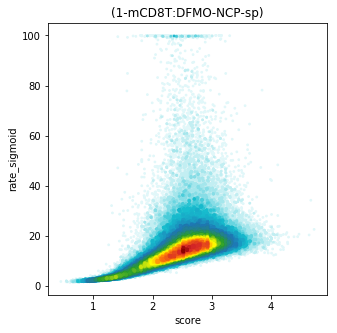



(1, 'mCD8T:DFMO', 'NCP', 'sp') CP_sigmoid
(1, 'mCD8T:DFMO', 'NCP', 'sp') rate_sigmoid
Spearman: -0.89
Pearson: -0.58


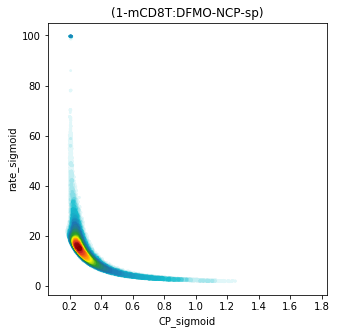



(2, 'mCD8T:DFMO', 'NCP', 'sp') score
(2, 'mCD8T:DFMO', 'NCP', 'sp') CP_sigmoid
Spearman: -0.68
Pearson: -0.68


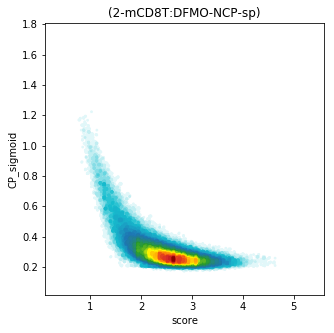



(2, 'mCD8T:DFMO', 'NCP', 'sp') score
(2, 'mCD8T:DFMO', 'NCP', 'sp') rate_sigmoid
Spearman: 0.58
Pearson: 0.39


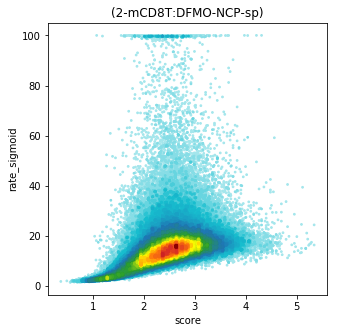



(2, 'mCD8T:DFMO', 'NCP', 'sp') CP_sigmoid
(2, 'mCD8T:DFMO', 'NCP', 'sp') rate_sigmoid
Spearman: -0.86
Pearson: -0.53


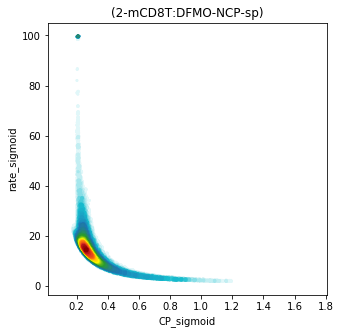



(1, 'mCD8T:ODCKO', 'NCP', 'sp') score
(1, 'mCD8T:ODCKO', 'NCP', 'sp') CP_sigmoid
Spearman: -0.80
Pearson: -0.76


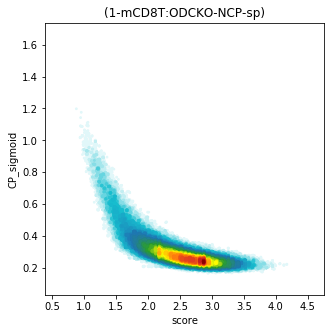



(1, 'mCD8T:ODCKO', 'NCP', 'sp') score
(1, 'mCD8T:ODCKO', 'NCP', 'sp') rate_sigmoid
Spearman: 0.72
Pearson: 0.61


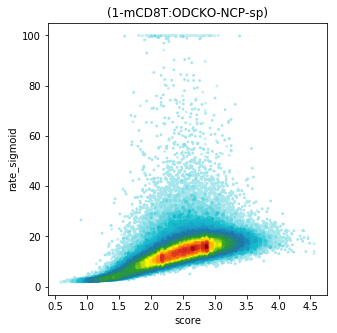



(1, 'mCD8T:ODCKO', 'NCP', 'sp') CP_sigmoid
(1, 'mCD8T:ODCKO', 'NCP', 'sp') rate_sigmoid
Spearman: -0.87
Pearson: -0.66


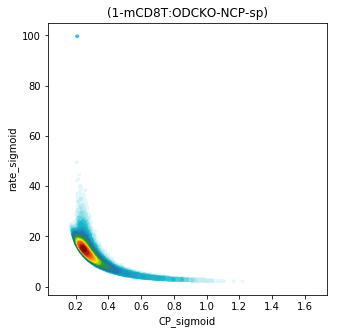



(2, 'mCD8T:ODCKO', 'NCP', 'sp') score
(2, 'mCD8T:ODCKO', 'NCP', 'sp') CP_sigmoid
Spearman: -0.77
Pearson: -0.73


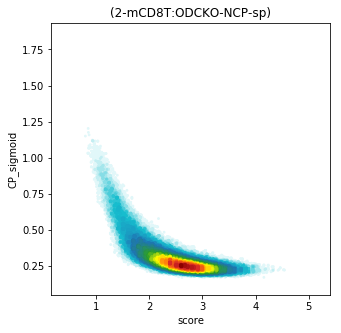



(2, 'mCD8T:ODCKO', 'NCP', 'sp') score
(2, 'mCD8T:ODCKO', 'NCP', 'sp') rate_sigmoid
Spearman: 0.70
Pearson: 0.60


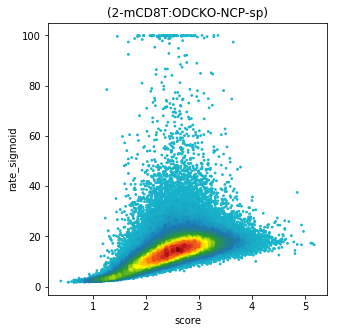



(2, 'mCD8T:ODCKO', 'NCP', 'sp') CP_sigmoid
(2, 'mCD8T:ODCKO', 'NCP', 'sp') rate_sigmoid
Spearman: -0.88
Pearson: -0.68


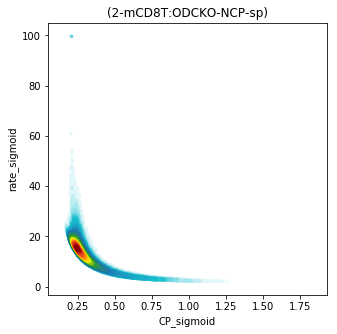

In [35]:
### compare Condensability Score vs CP(point) vs CR(rate) for each data
metrics = ['score', 'CP_sigmoid', 'rate_sigmoid']
for dexp in dexp_list:
    for i in range(len(metrics)-1):
        for j in range(i+1, len(metrics)):
            metric1 = metrics[i]
            metric2 = metrics[j]
            
            X = [dexp_ID_field_value[dexp][ID][metric1] for ID in ID_list]
            Y = [dexp_ID_field_value[dexp][ID][metric2] for ID in ID_list]

            spearman_corr = scipy.stats.spearmanr(X, Y)[0]
            pearson_corr = scipy.stats.pearsonr(X, Y)[0]
            print dexp, metric1
            print dexp, metric2
            print "Spearman: %1.2f" % (spearman_corr)
            print "Pearson: %1.2f" % (pearson_corr)

            fig = plt.figure(figsize=(5,5))
            graphics.density_scatter (X, Y, bins=200, ax=plt.gca())
            #plt.plot(X, Y, 'k,', alpha=0.5)
            plt.xlabel(metric1)
            plt.ylabel(metric2)
            #plt.xscale('log', base=2)
            #plt.yscale('log', base=2)
            #plt.axis('square')
            #plt.xlim([0,2])
            #plt.ylim([0,2])
            plt.title("(%d-%s-%s-%s)" % dexp)
            plt.show()
            plt.close()
            print
            print
        

In [14]:
### reorganize data and make labels
dexp_label = {}
dexp_CP, dexp_CR = {}, {}
for dexp in dexp_list:
    rep, cell, sample, agent = dexp
    label = '%s \n %s %s \n %d-rep' % (cell, sample, agent, rep)
    dexp_label[dexp] = label
    dexp_CP[dexp] = [dexp_ID_field_value[dexp][ID]['CP_sigmoid'] for ID in ID_list]
    dexp_CR[dexp] = [dexp_ID_field_value[dexp][ID]['rate_sigmoid'] for ID in ID_list]
    


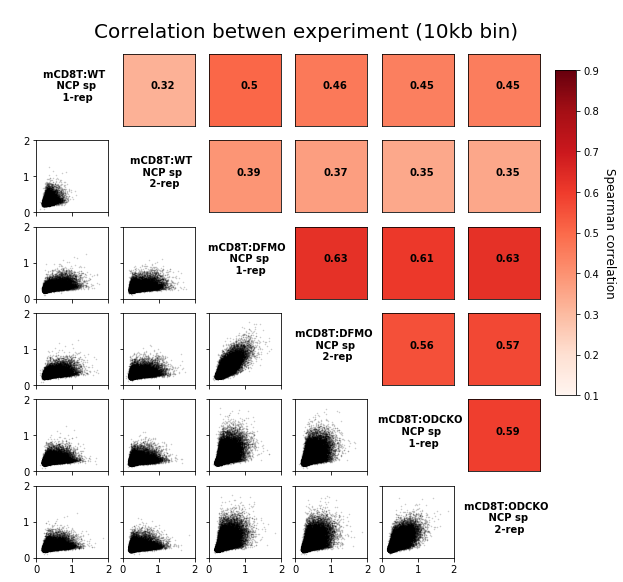

In [40]:
# plot correlation matrix between experiment (CP)
graphics.plot_corr_matrix(dexp_CP,
                          dexp_label,
                          ids = dexp_list,
                          xlim=[0, 2],
                          ylim=[0, 2],
                          scatter_style='dot',
                          alpha=0.2,
                          bins=100,
                          cbar=True,
                          save=False,
                          title = "Correlation betwen experiment (10kb bin)",
                          note='10kb')

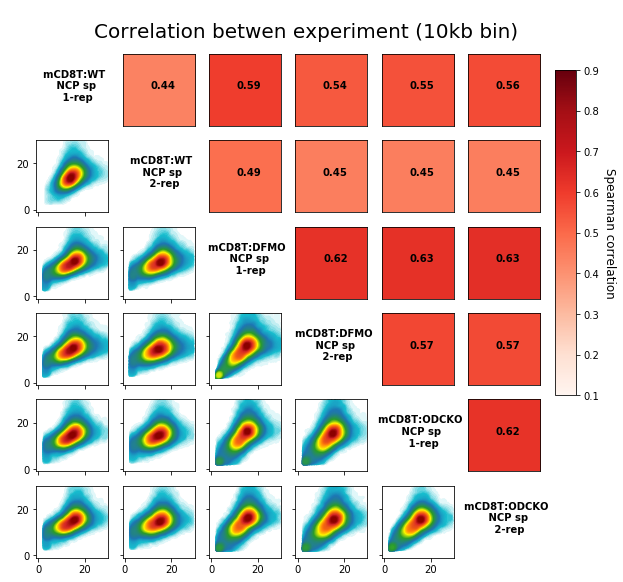

In [20]:
# plot correlation matrix between experiment (CR)
graphics.plot_corr_matrix(dexp_CR,
                          dexp_label,
                          ids = dexp_list,
                          xlim=[-1, 30],
                          ylim=[-1, 30],
                          scatter_style='density',
                          bins=200,
                          cbar=True,
                          save=False,
                          title = "Correlation betwen experiment (10kb bin)",
                          note='10kb')
